In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import sys
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import sys
sys.path.append('../src')
import score_funcs
import argparse
import numpy as np
from score_funcs import gradient_sum,eg_scores_2d,cdep
import os
import random
from tqdm import tqdm
import torch.nn as nn
import pickle as pkl
from copy import deepcopy

from model import Net 
from skimage.transform import resize
sys.path.append("../../pytorch-AdaIN")
import argparse
from pathlib import Path
from function import coral
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image

import net
from function import adaptive_instance_normalization, coral


In [4]:
def test_transform(size, crop):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform


def style_transfer(vgg, decoder, content, style, alpha=1.0,
                   interpolation_weights=None):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    if interpolation_weights:
        _, C, H, W = content_f.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = adaptive_instance_normalization(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        content_f = content_f[0:1]
    else:
        feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder = net.decoder
vgg = net.vgg

decoder.eval()
vgg.eval()

decoder.load_state_dict(torch.load('models/decoder.pth'))
vgg.load_state_dict(torch.load('models/vgg_normalised.pth'))
vgg = nn.Sequential(*list(vgg.children())[:31])

vgg.to(device);
decoder.to(device);


In [14]:
def test_transform(size, ):
    transform_list = []
    transform_list.append(transforms.ToPILImage())
    if size != 0:
        transform_list.append(transforms.Resize(size,interpolation = 1))

    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform
content_tf = test_transform(512,)

In [7]:
CIFAR_NUMPY = './data/cifar-10-batches-py/test_batch' 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
CIFAR = unpickle(CIFAR_NUMPY)[b'data']
CIFAR = CIFAR/255.0
CIFAR = CIFAR.reshape((-1, 3, 32,32))
def load_image_from_cifar(image_id):
    """This is to load the image from CIFAR numpy and pre-process.

    :param image_id: An integer as the image id to load from CIFAR.
    :return img: A PyTorch Tensor.
    """
    image = CIFAR[image_id]


    image = torch.from_numpy(image)
    image = image.unsqueeze(0)  # Change from 3D to 4D
    image = image.float()
    return image


In [8]:
unpickle(CIFAR_NUMPY).keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [16]:
from tqdm import tqdm_notebook

In [41]:
num_imgs = 100
CIFAR_stylized = np.empty_like(CIFAR[:num_imgs])
np.random.seed(0)
alpha = .75

with torch.no_grad():
    
    for i in tqdm_notebook(range(len(CIFAR_stylized))):
        style_img = load_image_from_cifar(np.random.choice(len(CIFAR)))
        content_img = load_image_from_cifar(i)
        
        img = style_transfer(vgg, decoder, content_tf(content_img[0]).cuda().unsqueeze(0), content_tf(style_img[0]).cuda().unsqueeze(0),
                                alpha).detach().cpu().numpy()[0].swapaxes(0,2)
        CIFAR_stylized[i] = resize(img, (32,32,3),0).swapaxes(0,2)

In [42]:
CIFAR_stylized[CIFAR_stylized <0] =0
CIFAR_stylized[CIFAR_stylized >1] =1


In [43]:
pickle_dict ={'labels': unpickle(CIFAR_NUMPY)[b'labels'][:num_imgs], 'cifar': CIFAR[:num_imgs],'cifar_stylized':CIFAR_stylized }
pkl.dump(pickle_dict,open( "data_stylized2.pkl", "wb" ) )

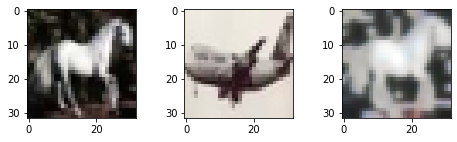

In [50]:
fig, axes = plt.subplots(ncols = 3, figsize = (8,2))
num +=1
axes[0].imshow(CIFAR[num].swapaxes(0,2).swapaxes(0,1));
axes[1].imshow(style_img.cpu().numpy()[0].swapaxes(0,2).swapaxes(0,1));
axes[2].imshow(CIFAR_stylized[num].swapaxes(0,2).swapaxes(0,1));